
# Uma breve introdução ao Machine Learning: Dia 3

Gabriel Wendell Celestino Rocha

Material de um minicurso de introdução ao Machine Learning oferecido pelo [PET - Física](https://petfisica.home.blog).

O conteúdo é mantido no [GitHub](https://github.com/GabrielWendell/Intro_ML) e distribuídos sob uma [licença BSD3](https://opensource.org/licenses/BSD-3-Clause).

- [Veja a tabela de conteúdos](https://github.com/GabrielWendell/Intro_ML/blob/main/Infomações/Conteúdos.ipynb)

Este `Notebook` pode, opcionalmente, ser visto como uma [apresentação de slides](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f). Para apresentar os slides localmente, use:

```Python
$ jupyter nbconvert Dia3.ipynb --to slides --post serve
```

---

### Bibliotecas necessárias

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib notebook

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                        top = True,right = True, length = 5,width = 1,labelsize = 15)
    plt.tick_params(axis='both',which='major', direction = "in",
                        top = True,right = True, length = 8,width = 1,labelsize = 15)

### Versões das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Pandas, Seaborn

Software versions
Python 3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.0.1
OS Windows 10 10.0.19043
Matplotlib 3.5.1
Numpy 1.22.2
Pandas 1.4.0
Seaborn 0.11.2
Thu Jul 07 07:20:46 2022 Hora Padrão de Buenos Aires

#### Instalação:

```
$ pip install version_information
```

---

# Baixando os dados

In [3]:
a_data = pd.read_hdf('Data/cluster_a_data.hf5') 
b_data = pd.read_hdf('Data/cluster_b_data.hf5') 
c_data = pd.read_hdf('Data/cluster_c_data.hf5') 
d_data = pd.read_hdf('Data/cluster_d_data.hf5') 

In [4]:
cluster_3d = pd.read_hdf('data/cluster_3d_data.hf5')

In [5]:
cosmo_data = pd.read_hdf('Data/cosmo_data.hf5')

In [6]:
cosmo_data.describe()

,omega_b,omega_cdm,ln10^{10}A_s,H0
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.022252,0.119777,3.094768,67.284306
std,0.000923,0.008673,0.196490,3.833436
min,0.020650,0.104801,2.754002,60.670622
25%,0.021460,0.112233,2.924718,63.934918
50%,0.022250,0.119758,3.093983,67.305942
75%,0.023048,0.127305,3.265802,70.633425
max,0.023850,0.134800,3.433990,73.869231


# SciKit Learn

Normalmente não incluímos o [pacote SciKit Learn](https://scikit-learn.org/stable/) no nosso preâmbulo padrão, pois contém muitos módulos (sub-pacotes). Em vez disso, importamos cada módulo conforme necessário. Os que precisamos agora são:

In [7]:
from sklearn import preprocessing, cluster

# Localizando estruturas em dados

O tipo de estrutura que podemos procurar são "*clusters*" (ou aglomerados) de *samples* "próximos", mas a definição desses termos requer alguns cuidados.

## 1. Distância entre *samples*

No caso mais simples, todos os *samples* $x_{j}$ têm as mesmas unidades (possivelmente adimensionais), e a distância natural entre os *samples* (linhas) $j$ e $k$ é:

$$\boxed{d(j,k)=\sum_{\text{features i}}(x_{ji}-x_{ki})^{2}}$$

No entanto, e se algumas colunas tiverem unidades diferentes? Por exemplo, qual é a distância entre os dois *samples* abaixo:

$$(\text{1.2},\text{ 0.4 cm},\text{ 5.2 kPa})$$

$$(\text{0.7},\text{ 0.5 cm},\text{ 4.9 kPa})$$

Os algoritmos de ML geralmente são independentes de unidade, portanto, combinarão alegremente recursos com unidades diferentes, mas isso pode não ser o que você realmente deseja.

Uma solução razoável é normalizar cada recurso com a [transformação esférica](https://en.wikipedia.org/wiki/Whitening_transformation):

$$\boxed{x\rightarrow\frac{(x-\mu)}{\sigma}}$$

onde $\mu$ e $\sigma$ são a média e o desvio padrão dos valores originais do *sample*.

O módulo [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) automatiza esse processo com:

In [8]:
cosmo_normed = cosmo_data.copy()
cosmo_normed[cosmo_data.columns] = preprocessing.scale(cosmo_data)

cosmo_normed.describe()

,omega_b,omega_cdm,ln10^{10}A_s,H0
count,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04
mean,1.972644e-17,4.425349e-17,1.337198e-15,1.869744e-15
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.735789e+00,-1.726691e+00,-1.734287e+00,-1.725280e+00
25%,-8.584267e-01,-8.697915e-01,-8.654500e-01,-8.737388e-01
50%,-1.958299e-03,-2.131438e-03,-3.995583e-03,5.644049e-03
75%,8.617981e-01,8.679544e-01,8.704566e-01,8.736686e-01
max,1.731191e+00,1.732135e+00,1.726426e+00,1.717778e+00


No entanto, isso pode descartar informações úteis contidas na normalização relativa entre os recursos. Para normalizar apenas determinadas colunas use, por exemplo:

In [9]:
cosmo_normed = cosmo_data.copy()
for colname in 'ln10^{10}A_s', 'H0':
    cosmo_normed[colname] = preprocessing.scale(cosmo_data[colname])

## 2. O que é um "*cluster*"?

No caso mais simples (a), os clusters são bem separados por uma linha (em 2D, ou hiperplano em mais dimensões) e podem ser identificados sem ambiguidade observando-se apenas a distância entre pares de amostras.

Na prática, os *clusters* podem se sobrepor levando a ambiguidades (b), ou os clusters que esperamos encontrar podem exigir a consideração de grupos de mais de duas amostras por vez (c), ou podem ter um limite de separação não linear (d).

![image](img\cluster_types.png)

## 3. Agrupamento de K-médios (*K-means clustering*)

O [algoritmo K-means](https://en.wikipedia.org/wiki/K-means_clustering) é rápido e robusto, mas pressupõe que seus dados consistem em clusters aproximadamente redondos do mesmo tamanho (onde os significados de "redondo" e "tamanho" dependem de como seus dados são dimensionados).

A maioria dos algoritmos `sklearn` usa um padrão de chamada semelhante:

```Python
result = module.ClassName(..args..).fit(data)
```

Para o [algoritmo KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans):

In [10]:
a_fit = cluster.KMeans(n_clusters = 2).fit(a_data)

Usaremos a seguinte função para exibir os resultados do cluster 2D (não se preocupe com os [detalhes](https://seaborn.pydata.org/tutorial/color_palettes.html), a menos que esteja interessado):

In [11]:
def display(data, fit):
    n_clusters = len(np.unique(fit.labels_))
    import matplotlib.colors
    plt.figure(figsize = (8, 5))
    cmap = matplotlib.colors.ListedColormap(sns.color_palette('viridis', n_clusters).as_hex())
    opt_plot()
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], s = 10, c = fit.labels_, cmap = cmap)
    plt.xlim(-9, 9)
    plt.ylim(-5, 5)
    plt.gca().set_aspect(1.)

<IPython.core.display.Javascript object>


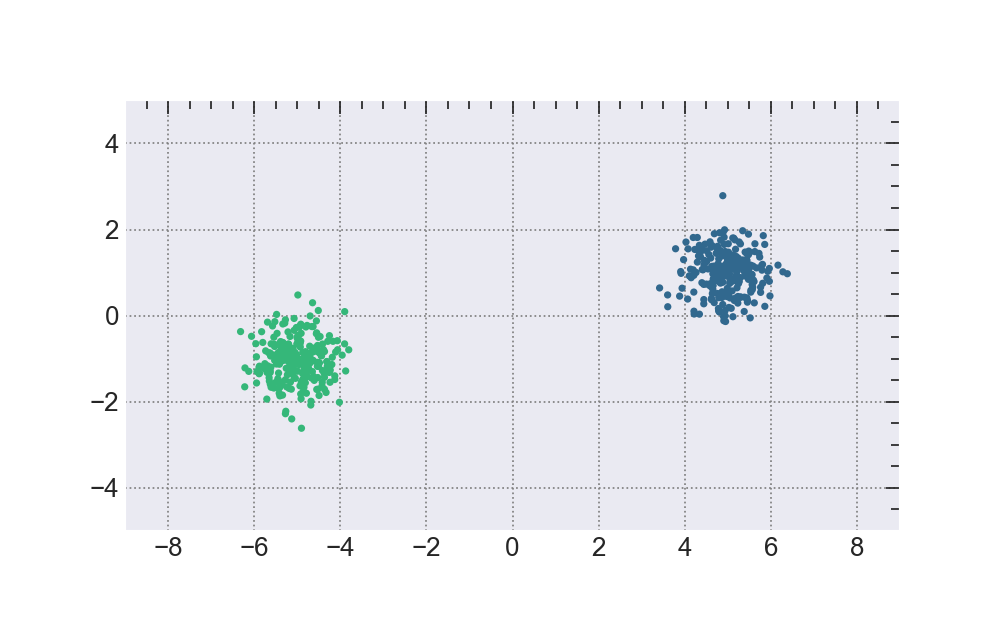

In [12]:
display(a_data, a_fit)

Vamos usar o KMeans para ajustar os três outros conjuntos de dados 2D (b, c, d) com `n_clusters = 2` e gerar gráficos semelhantes. 

<IPython.core.display.Javascript object>


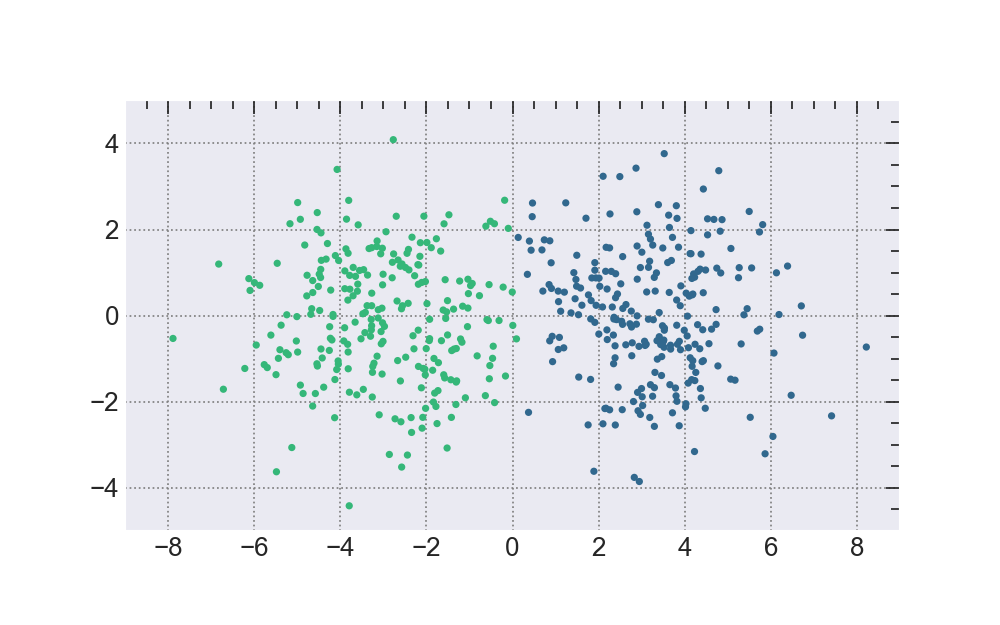

In [13]:
b_fit = cluster.KMeans(n_clusters = 2).fit(b_data)
display(b_data, b_fit)

<IPython.core.display.Javascript object>


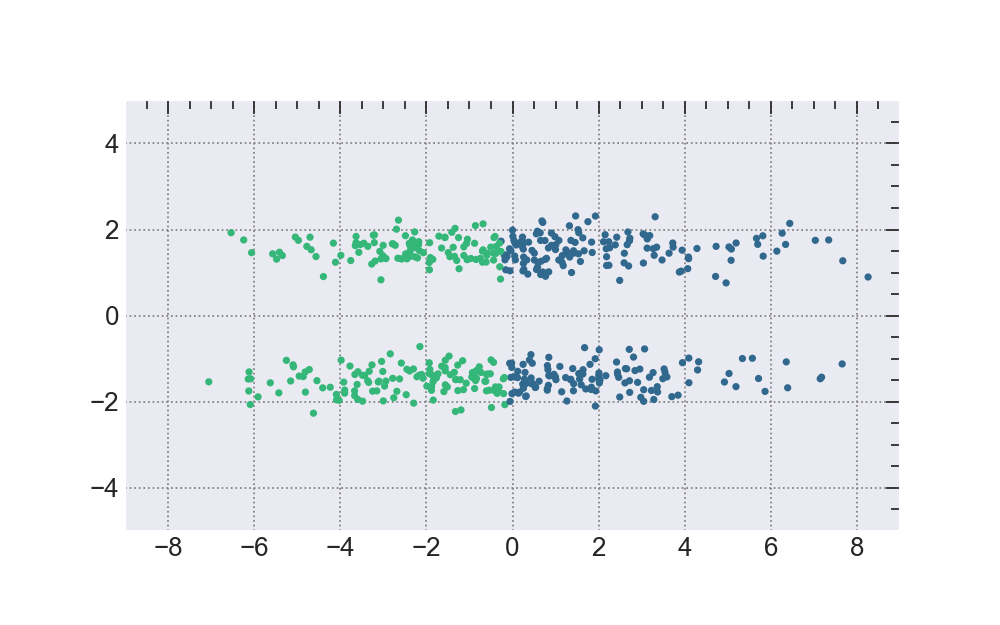

In [14]:
c_fit = cluster.KMeans(n_clusters = 2).fit(c_data)
display(c_data, c_fit)

<IPython.core.display.Javascript object>


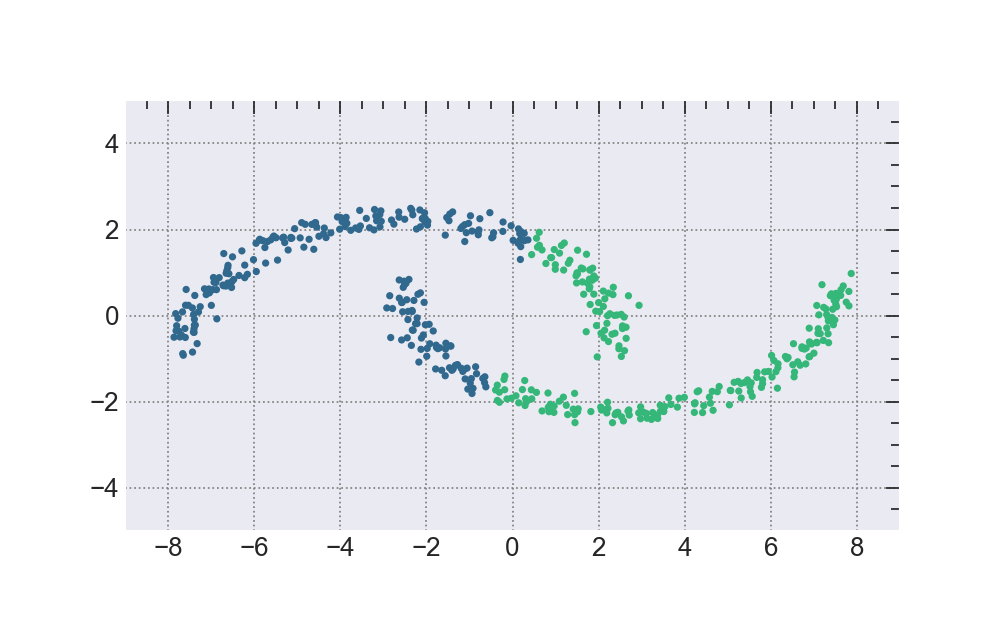

In [15]:
d_fit = cluster.KMeans(n_clusters = 2).fit(d_data)
display(d_data, d_fit)

Os resultados de ajuste parecem razoáveis para (b), embora a linha divisória nítida entre os dois grupos pareça artificial.

Os resultados de ajuste para (c) e (d) não correspondem ao que esperamos porque o KMeans considera apenas um par de cada vez, portanto, não pode identificar padrões de escala maiores que são óbvios a olho nu.

## 4. Hiperparâmetros

Os algoritmos têm muitos parâmetros que influenciam seus resultados para um determinado conjunto de dados, mas eles se enquadram em duas categorias:

- Parâmetros cujos valores são determinados pelos dados durante o processo de ajuste.
- Parâmetros que devem ser ajustados externamente.

Referimo-nos ao segundo grupo como "hiperparâmetros" e definimos seus valores durante o processo de "seleção do modelo", que discutiremos mais adiante.

**QUESTIONAMENTO:** Todos os argumentos do construtor KMeans são hiperparâmetros?

Em princípio, sim, mas na prática alguns desses argumentos não terão (ou terão um impacto mínimo) no resultado do algoritmo em condições normais. Os argumentos que são mais claramente hiperparâmetros são:

```Python
n_clusters, algorithm, tol
```

Os argumentos que claramente não são hiperparâmetros são:

```Python
verbose, precompute_distances, n_jobs
```

Os argumentos restantes estão na área cinza. Em geral, é prudente experimentar seus dados reais para identificar quais argumentos afetam significativamente seus resultados.

Vamos ajustar o conjunto de dados (b) com o hiperparâmetro `n_clusters` definido como 3 e exibir os resultados. Comparando com o ajuste de 2 *clusters* anteriores, a olho nu, o que você acha que é o número "verdadeiro" de *clusters*? Como você pode decidir entre 2 e 3 mais objetivamente?

<IPython.core.display.Javascript object>


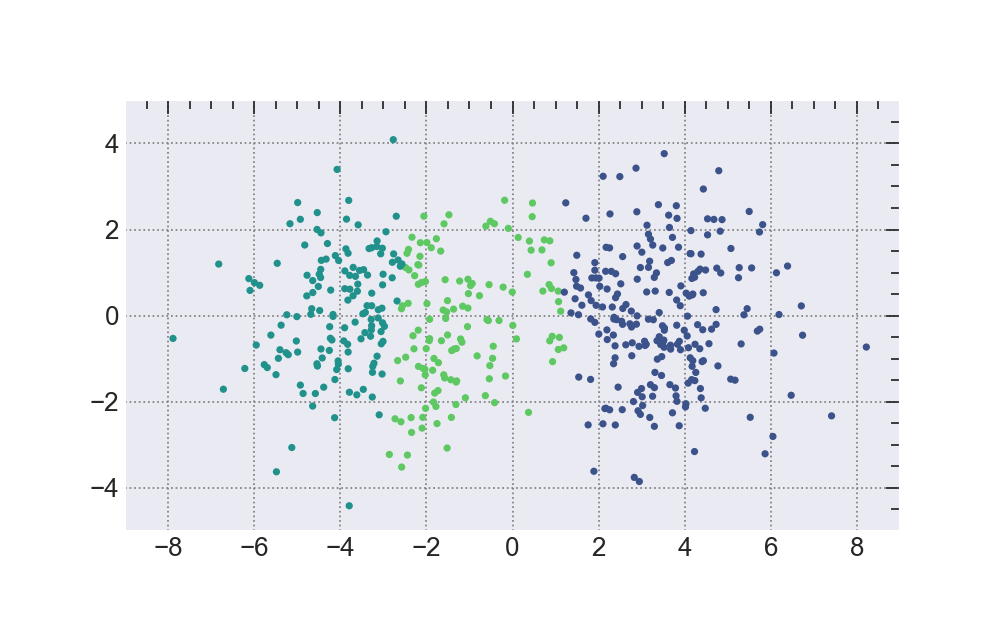

In [16]:
b_fit_3 = cluster.KMeans(n_clusters = 3).fit(b_data)
display(b_data, b_fit_3)

O gráfico acima é um caso convincente (para mim, pelo menos) de que existem três grupos. No entanto, a "verdade" neste caso são dois *clusters*.

Isso ilustra os perigos de sobrepor um resultado de ajuste em seus dados: inevitavelmente "chama sua atenção" e torna o ajuste mais confiável. Procure exemplos disso ao ler jornais ou ouvir palestras!

## 5. Agrupamento em várias dimensões

Um algoritmo para encontrar clusters em dados 2D está apenas automatizando o que você já poderia fazer a olho nu. No entanto, a maioria dos algoritmos de agrupamento também funciona bem com dados dimensionais mais altos, onde os agrupamentos podem não ser visíveis em nenhuma projeção 2D única.

<IPython.core.display.Javascript object>


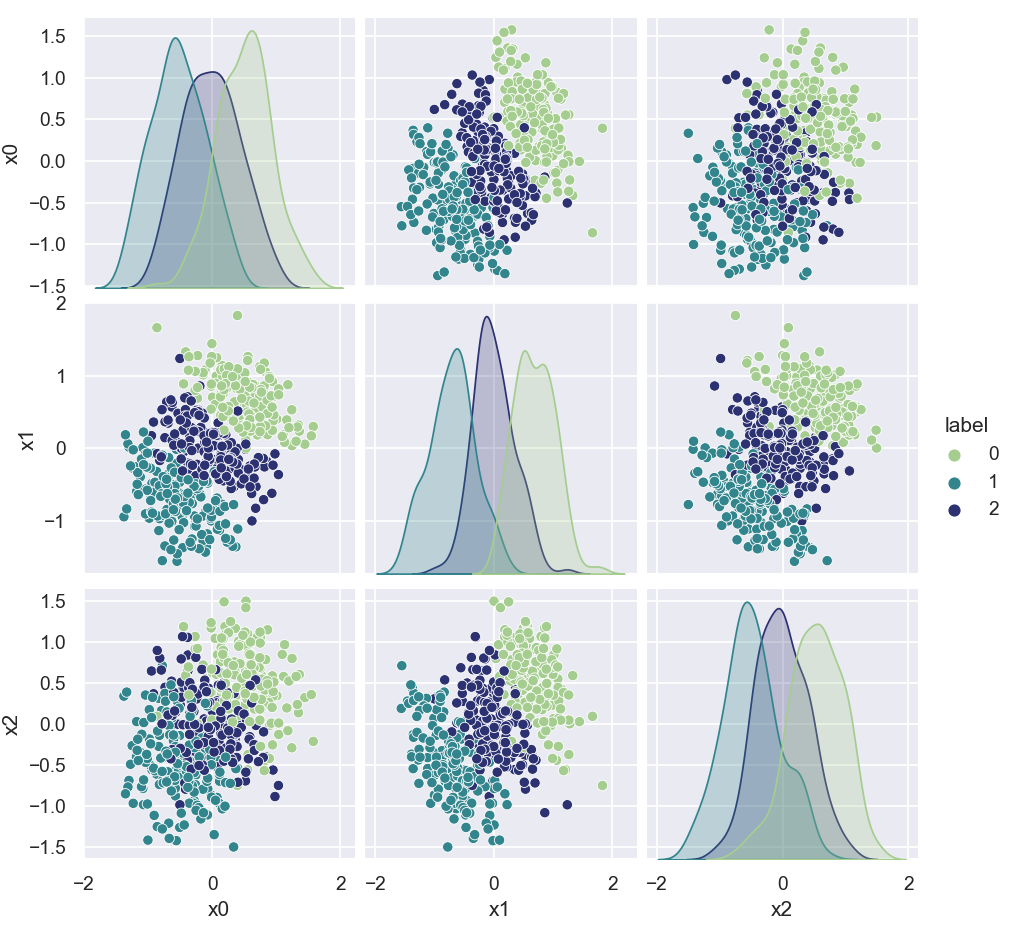

In [17]:
fit_3d = cluster.KMeans(n_clusters = 3).fit(cluster_3d)
cluster_3d['label'] = fit_3d.labels_
sns.pairplot(cluster_3d, vars = ('x0', 'x1', 'x2'), hue = 'label', palette = 'crest')
opt_plot()

Esses *clusters* parecem bastante arbitrários em cada um dos gráficos de dispersão 2D. No entanto, eles estão realmente muito bem separados, como podemos ver se girarmos os eixos!

<IPython.core.display.Javascript object>


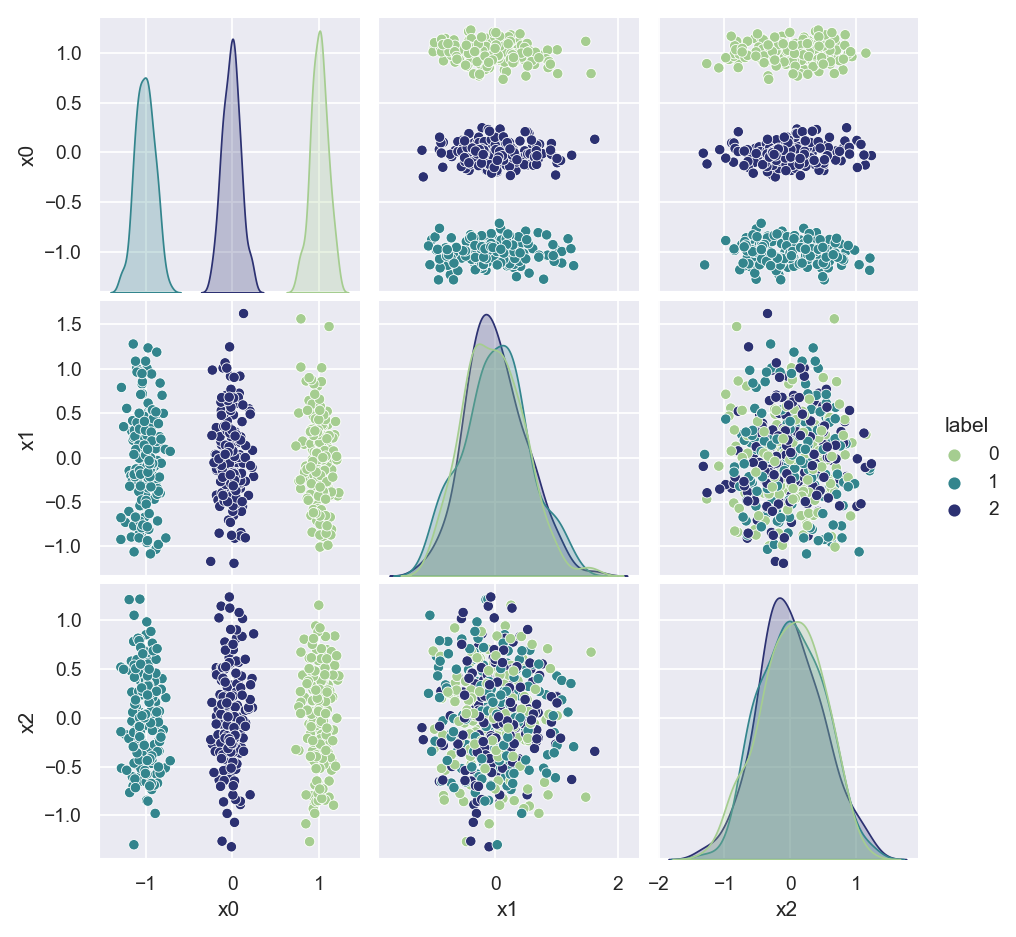

In [18]:
R = np.array(
    [[ 0.5  , -0.5  , -0.707],
     [ 0.707,  0.707,  0.   ],
     [ 0.5  , -0.5  ,  0.707]])
rotate_3d = cluster_3d.copy()
rotate_3d[['x0', 'x1', 'x2']] = cluster_3d[['x0', 'x1', 'x2']].dot(R)
sns.pairplot(rotate_3d, vars = ('x0', 'x1', 'x2'), hue = 'label', palette = 'crest')
opt_plot()

Este exemplo é artificial, mas a lição é que os algoritmos de clustering podem descobrir uma estrutura de dimensão superior que você pode perder com a visualização!

## 6. Anatomia de um algoritmo de *Machine Learning*

Agora que apresentamos nosso primeiro algoritmo de ML, este é um bom momento para alguns comentários gerais.

A maioria dos algoritmos de ML tem alguns recursos comuns:

- Eles procuram maximizar (ou minimizar) alguma função objetivo $f(\theta,D)$ dos dados (fixos) $D$, para alguns parâmetros (desconhecidos).

- A função objetivo incorpora algum modelo (talvez apenas implicitamente) de como se espera que os dados se pareçam.

A função objetivo do algoritmo KMeans é:

$$\boxed{\sum_{i=1}^{n}\sum_{c_{j}=1}|x_{j}-\mu_{i}|^{2}}$$

onde $c_{j}=1$ se o *sample* $j$ for atribuído ao *cluster* $i$ e $c_{j}=0$ caso contrário. Além disso

$$\boxed{\mu_{i}=\sum_{c_{j}=1}x_{j}}$$

é a média das amostras atribuídas ao *cluster* $i$. A soma externa é sobre o número de clusters $n$ e os índices dos *samples* $j$. Se considerarmos o *sample* $x_{j}$ para ser um vetor, então seus elementos são os valores das *features*.

**QUESTIONAMENTO:** Quais são os parâmetros da função objetivo do KMeans? Quantos parâmetros existem?

Os parâmetros são os valores binários $c_{j}$ e há um por amostra (linha). Observe que o número de parâmetros é independente do número de recursos (colunas) nos dados.

O número de clusters $n$ é um hiperparâmetro, pois é definido externamente e não ajustado pelo algoritmo em resposta aos dados.

As médias $\mu_{i}$ não são parâmetros independentes, pois seus valores são fixados pelo valores $c_{j}$ (fornecido nos dados).

## 7. Supervisionado vs Não supervisionado

Os algoritmos de ML vêm em dois tipos, dependendo se eles exigem alguns dados de treinamento em que você já sabe a resposta ("supervisionado") ou não ("não supervisionado"). Os algoritmos de agrupamento não são supervisionados.

Uma vantagem do ML não supervisionado é que ele funciona com qualquer dado de entrada e pode descobrir padrões que talvez você ainda não conheça (como no exemplo 3D acima). Mesmo quando você tem dados de treinamento disponíveis, um algoritmo não supervisionado ainda pode ser útil.

A desvantagem do aprendizado não supervisionado é que não podemos formular medidas objetivas para o desempenho de um algoritmo, de modo que os resultados são sempre um pouco subjetivos.

## 8. Maximização da expectativa

O algoritmo KMeans usa uma solução iterativa baseada no princípio [*Expectation-Maximization (EM)*](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm). Esta é uma abordagem poderosa usada por muitos algoritmos, que revisaremos várias vezes durante o curso e você explorará mais em uma tarefa de casa.

## 9. Outros métodos de agrupamento

Nós nos concentramos no KMeans como um algoritmo de agrupamento prototípico, mas [há muitos outros para escolher](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

Terminaremos esta seção com algumas breves experiências com duas alternativas que usam mais informações globais que o KMeans, portanto, são mais adequadas aos exemplos (c) e (d) acima:

- [Agrupamento espectral](https://en.wikipedia.org/wiki/Spectral_clustering): [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html).

- [Agrupamento espacial de aplicações com ruído baseado em densidade (DBSCAN)](https://en.wikipedia.org/wiki/DBSCAN): [`sklearn`](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering).

Vamos usar `cluster.SpectralClustering` para ajustar `c_data` e `d_data` e exibir os resultados. 

<IPython.core.display.Javascript object>


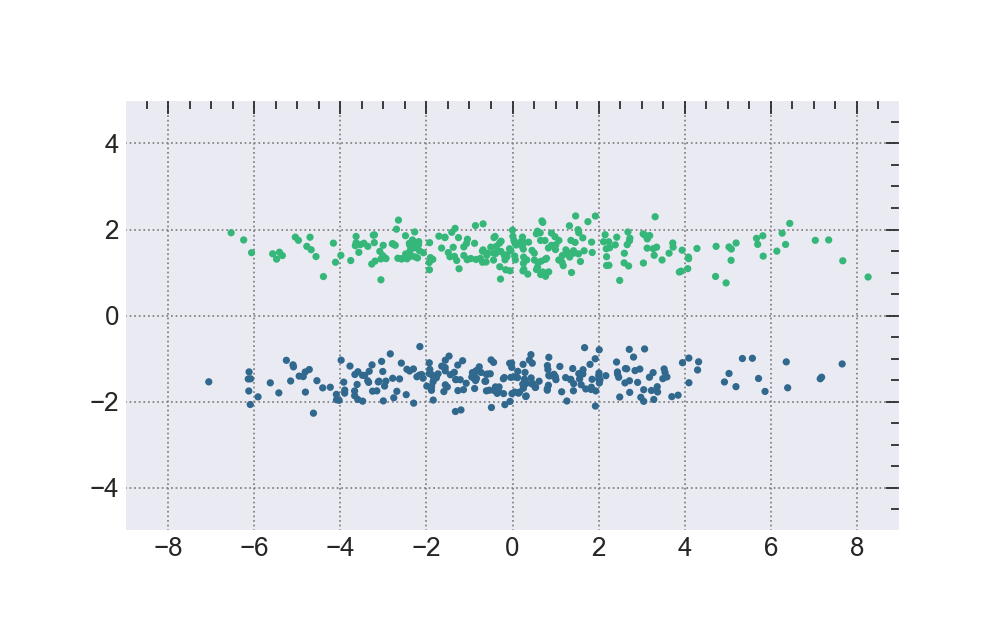

In [19]:
c_fit = cluster.SpectralClustering(n_clusters = 2).fit(c_data)
display(c_data, c_fit)

<IPython.core.display.Javascript object>


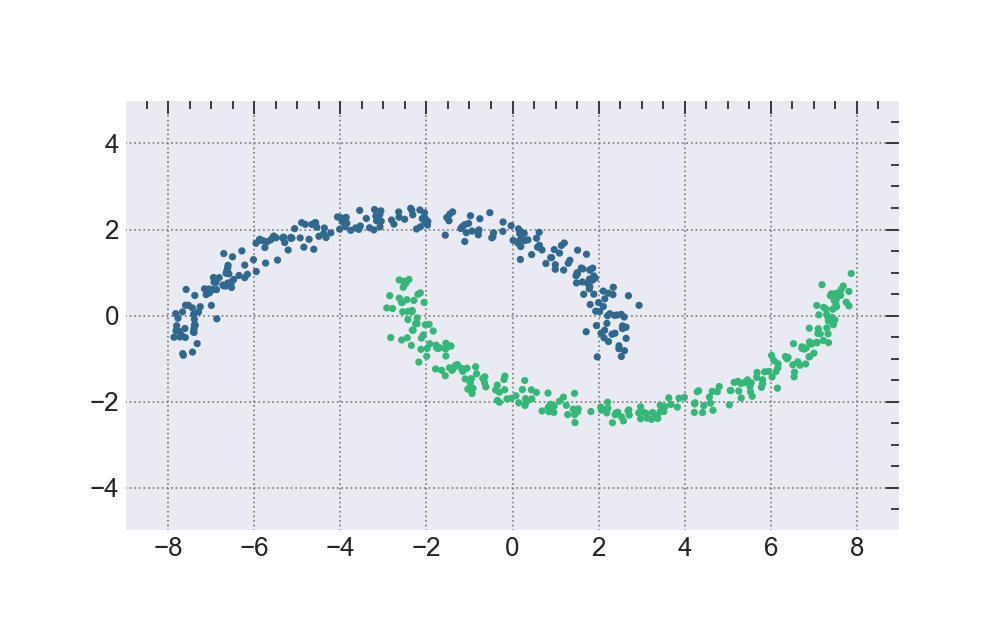

In [20]:
d_fit = cluster.SpectralClustering(n_clusters = 2, gamma = 2.0).fit(d_data)
display(d_data, d_fit)

Usemos agora `cluster.DBSCAN` para ajustar `c_data` e `d_data` e exibir os resultados. 

<IPython.core.display.Javascript object>


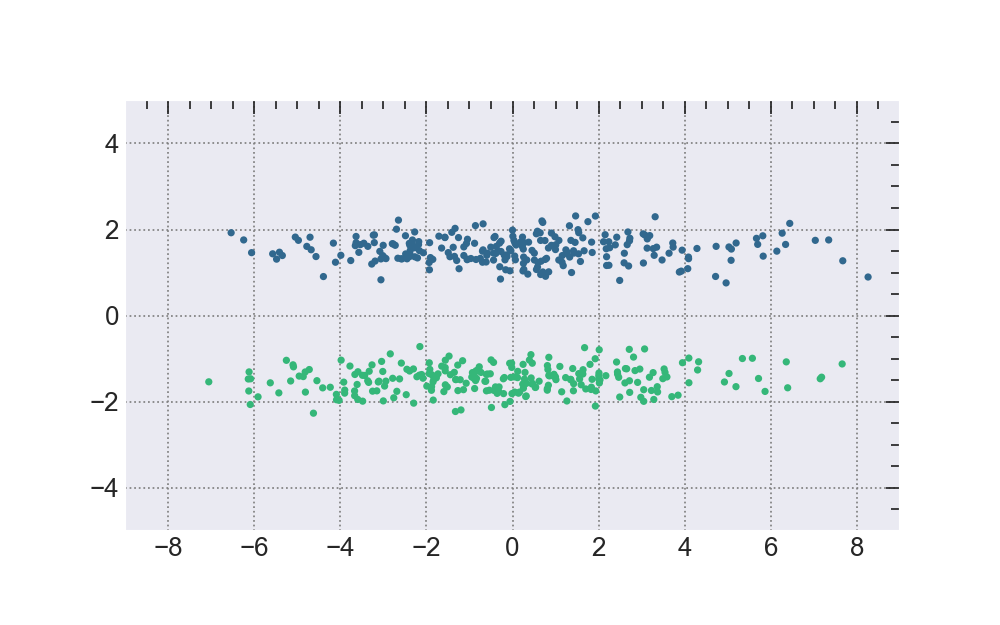

In [21]:
c_fit = cluster.DBSCAN(eps = 1.5).fit(c_data)
display(c_data, c_fit)

<IPython.core.display.Javascript object>


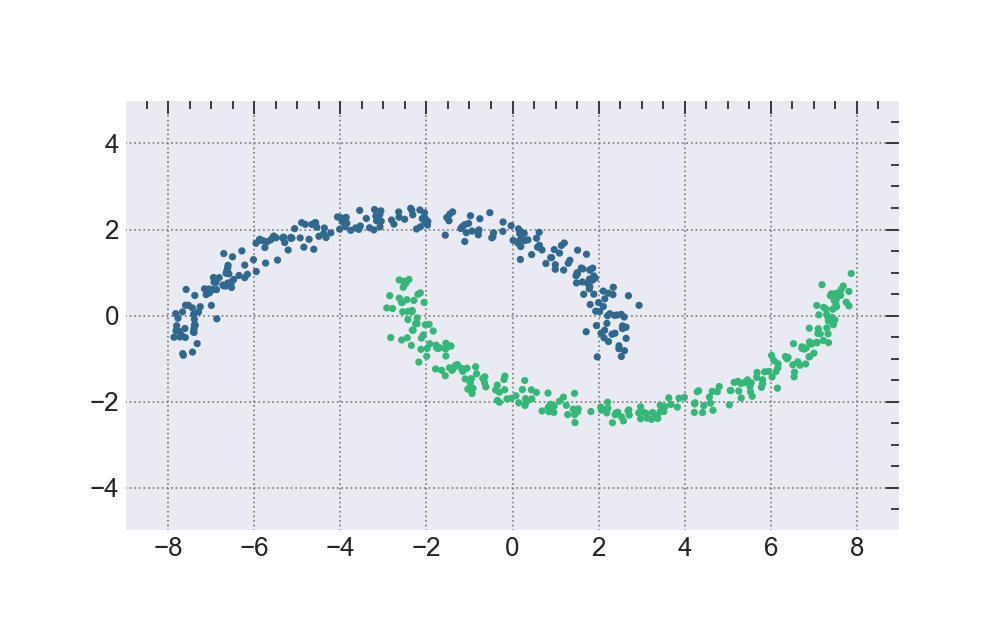

In [22]:
d_fit = cluster.DBSCAN().fit(d_data)
display(d_data, d_fit)

![image](https://c.tenor.com/hEOM8E4epvgAAAAC/hahaha-thats-all-folks.gif)

---

## Para se divertir!

- [Lista de problemas #03](https://github.com/GabrielWendell/Intro_ML/blob/main/Listas/Problemas3.ipynb)

---